In [1]:
!pip3 install pandas umap-learn matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='#3c3c3c'>Introduction</font>

text

# <font color='#3c3c3c'>EDA</font>

The first step we took was to find out some basic information about our dataset, such as the shape of the dataset, and the names of the columns available. We find out the number of rows and columns we have to gain a general overview of what data we have to analyze.

These are some general summary statistics about the data set. Some key observations include:
22,145 individual tracks 
18 features
10 numerical features
1 integer value (popularity)
7 categorical features 
0 duplicate entries
1 rows with a single missing value


From this initial exploration, we know that we have a very clean dataset with minimal missing values and no duplicate columns. This reduces the necessity for very intense data cleaning as the dataset is already relatively high quality. We can also note that the majority of features are continuous variables that represent Spotify's analysis metrics such as ‘energy’ and ‘danceability’. This is a positive, since it is ideal for modeling mood classification. We also know that since the dataset is very large, it is likely that the model will generalize well across different genres and moods. 

In [3]:
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (232725, 18)

Column Names:
 Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


In [5]:
# check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


In [6]:
# summary statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


<Axes: >

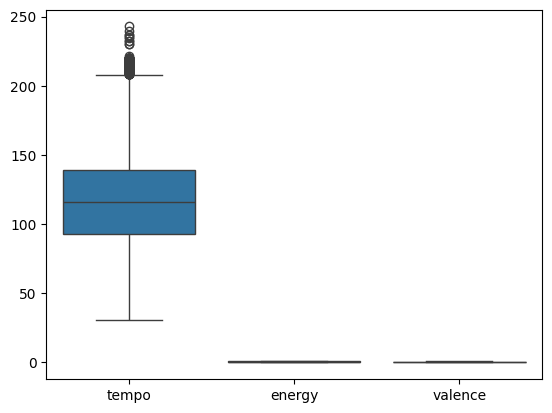

In [7]:
# Duplicate tracks
df.duplicated().sum()

# Outlier detection
sns.boxplot(data=df[['tempo', 'energy', 'valence']])


In [8]:
audio_features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'liveness', 'speechiness']


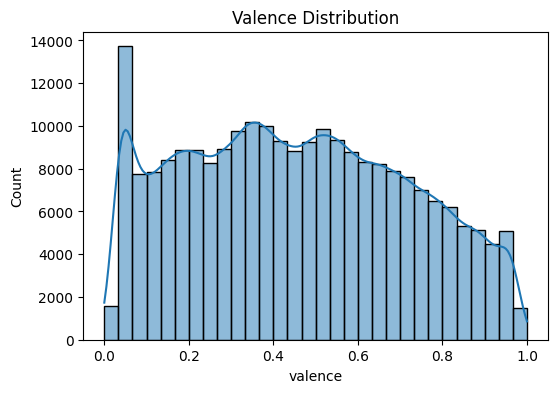

In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(df['valence'], kde=True, bins=30)
plt.title('Valence Distribution')
plt.show()


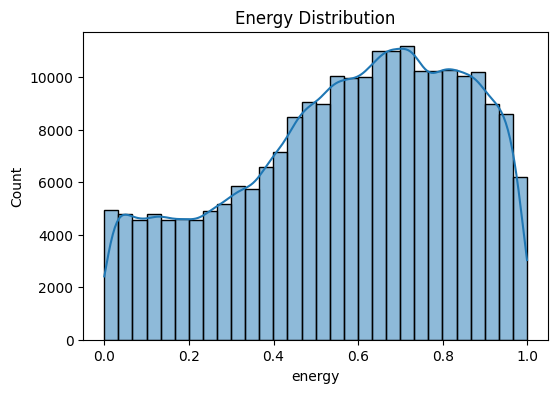

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(df['energy'], kde=True, bins=30)
plt.title('Energy Distribution')
plt.show()


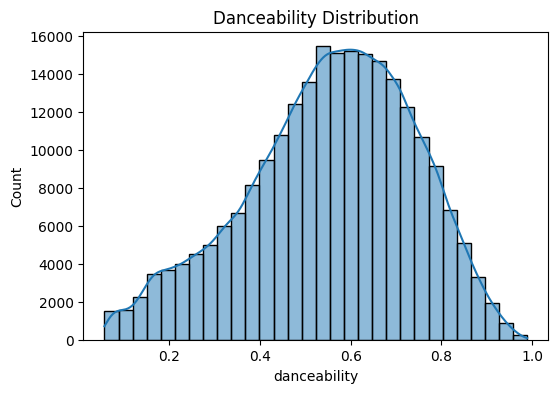

In [11]:
plt.figure(figsize=(6, 4))
sns.histplot(df['danceability'], kde=True, bins=30)
plt.title('Danceability Distribution')
plt.show()


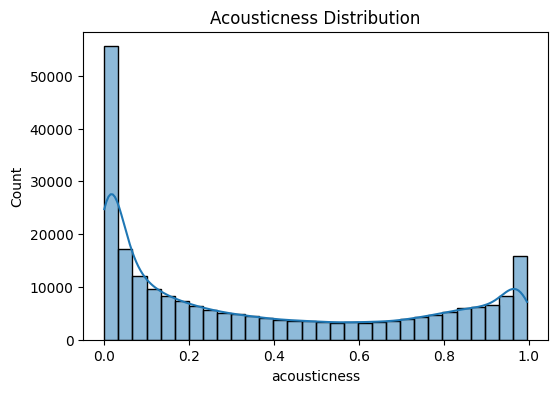

In [12]:
plt.figure(figsize=(6, 4))
sns.histplot(df['acousticness'], kde=True, bins=30)
plt.title('Acousticness Distribution')
plt.show()


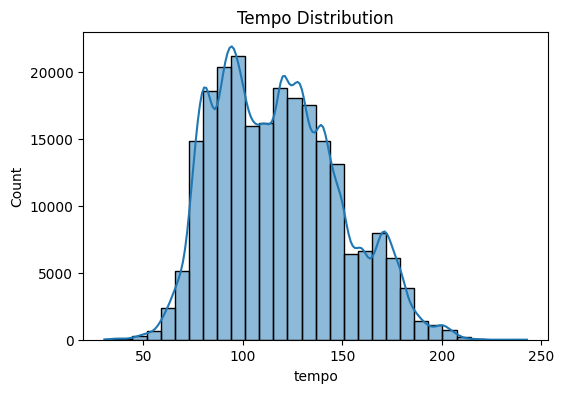

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(df['tempo'], kde=True, bins=30)
plt.title('Tempo Distribution')
plt.show()


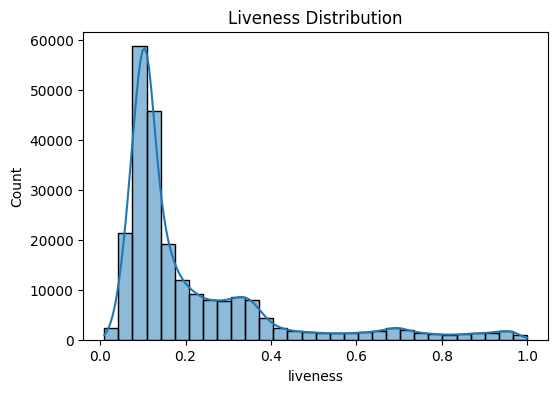

In [14]:
plt.figure(figsize=(6, 4))
sns.histplot(df['liveness'], kde=True, bins=30)
plt.title('Liveness Distribution')
plt.show()


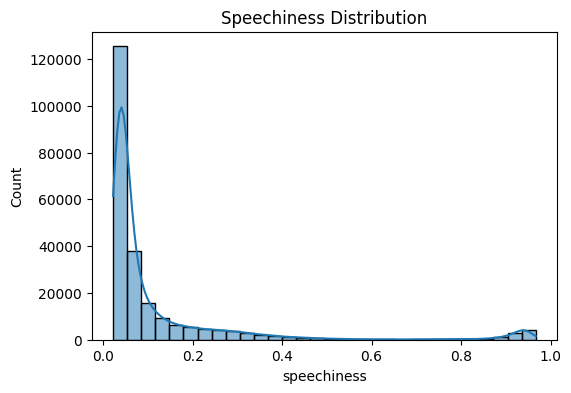

In [15]:
plt.figure(figsize=(6, 4))
sns.histplot(df['speechiness'], kde=True, bins=30)
plt.title('Speechiness Distribution')
plt.show()

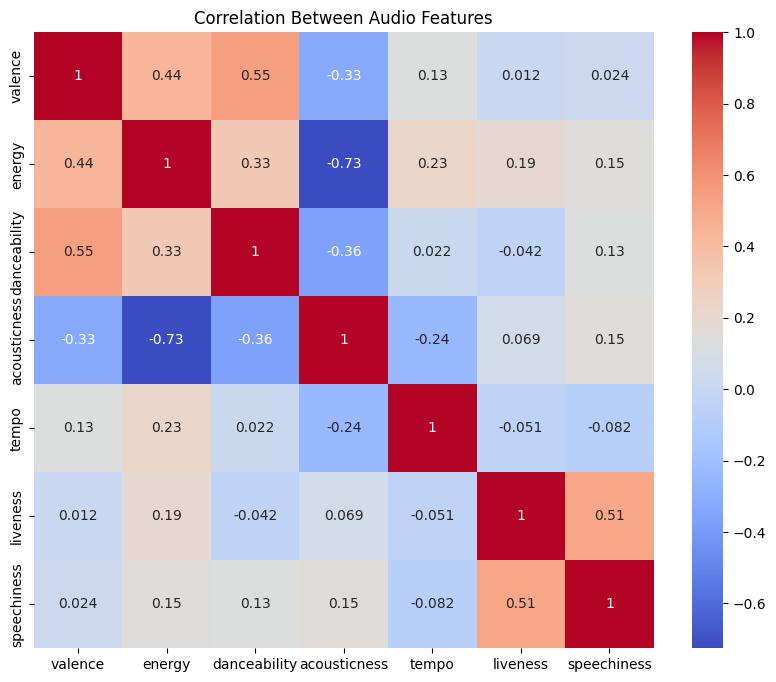

In [16]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Audio Features')
plt.show()


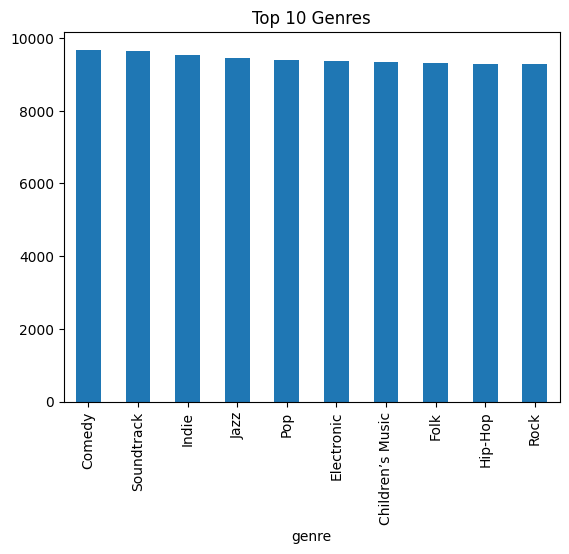

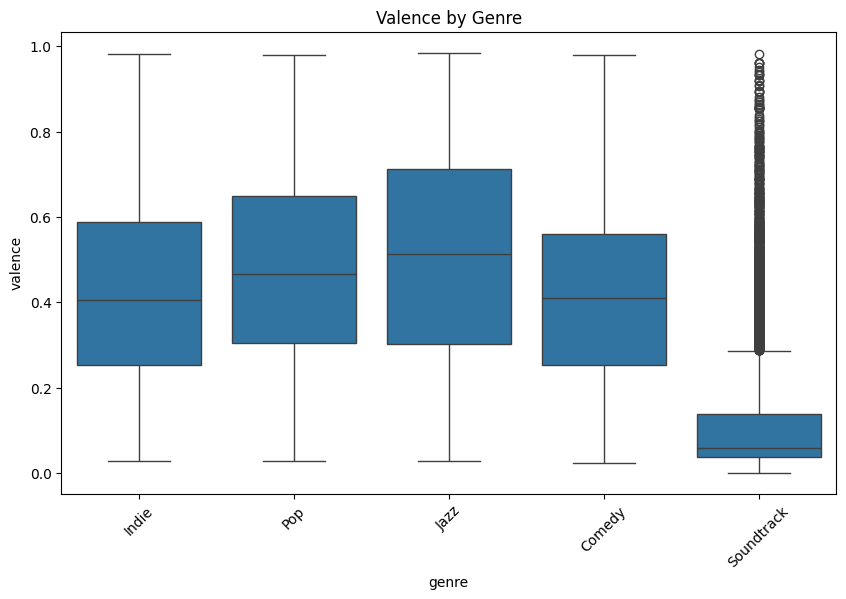

In [17]:
df['genre'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Genres')
plt.show()

# Boxplots of valence by genre
top_genres = df['genre'].value_counts().head(5).index
subset = df[df['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='valence', data=subset)
plt.title('Valence by Genre')
plt.xticks(rotation=45)
plt.show()

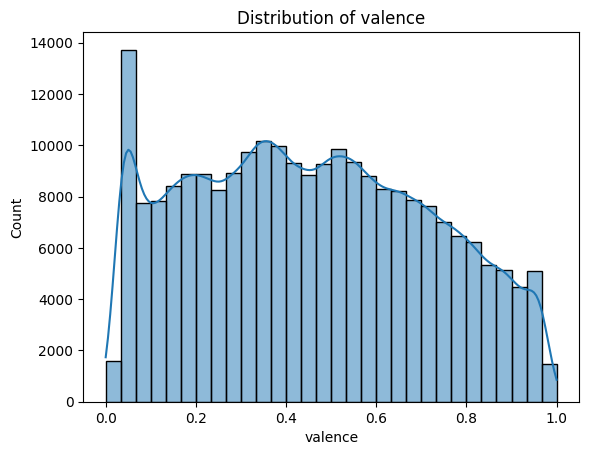

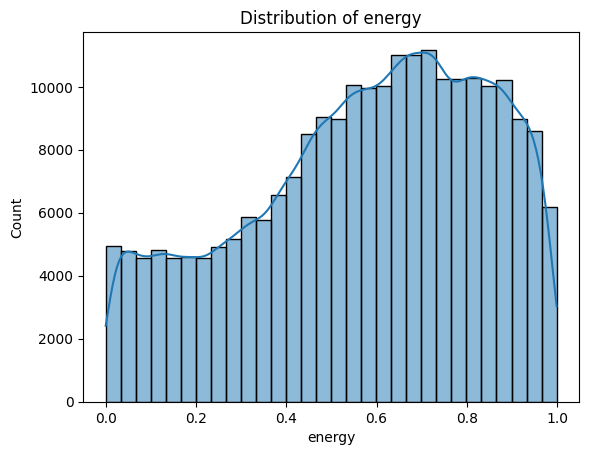

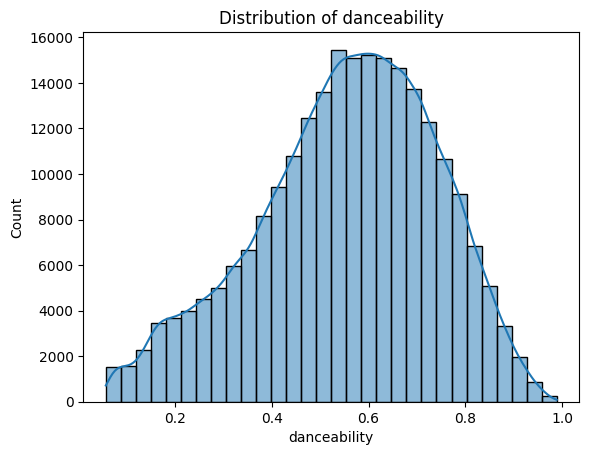

In [18]:
for feature in ['valence', 'energy', 'danceability']:
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

# <font color='#3c3c3c'>EDA-2</font>

In [19]:
features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'loudness', 
    'speechiness', 
    'instrumentalness', 
    'liveness']

X = df[features]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
from sklearn.cluster import KMeans

# Choose number of clusters (let's say 5 moods)
kmeans = KMeans(n_clusters=5, random_state=42)
df['mood_cluster'] = kmeans.fit_predict(X_scaled)

# Now each song is assigned to a "mood cluster"

In [22]:
cluster_summary = df.groupby('mood_cluster')[features].mean()
print(cluster_summary)

               valence    energy  danceability  acousticness       tempo  \
mood_cluster                                                               
0             0.336002  0.332763      0.506147      0.697375  111.752528   
1             0.640722  0.670030      0.704638      0.192694  108.926153   
2             0.155164  0.165379      0.292362      0.844025  102.478091   
3             0.414632  0.663503      0.562818      0.789351   98.023968   
4             0.430969  0.766319      0.503566      0.099973  142.572296   

               loudness  speechiness  instrumentalness  liveness  
mood_cluster                                                      
0            -12.008261     0.065861          0.066356  0.178686  
1             -7.041822     0.104922          0.059300  0.172583  
2            -20.922792     0.045696          0.740426  0.146678  
3            -11.988400     0.877456          0.001191  0.729090  
4             -5.947786     0.093683          0.091934  0.244200 

In [23]:
cluster_to_mood = {
    0: 'Happy Party',
    1: 'Sad Acoustic',
    2: 'Chill Vibes',
    3: 'Energetic',
    4: 'Mellow'
}

df['mood'] = df['mood_cluster'].map(cluster_to_mood)

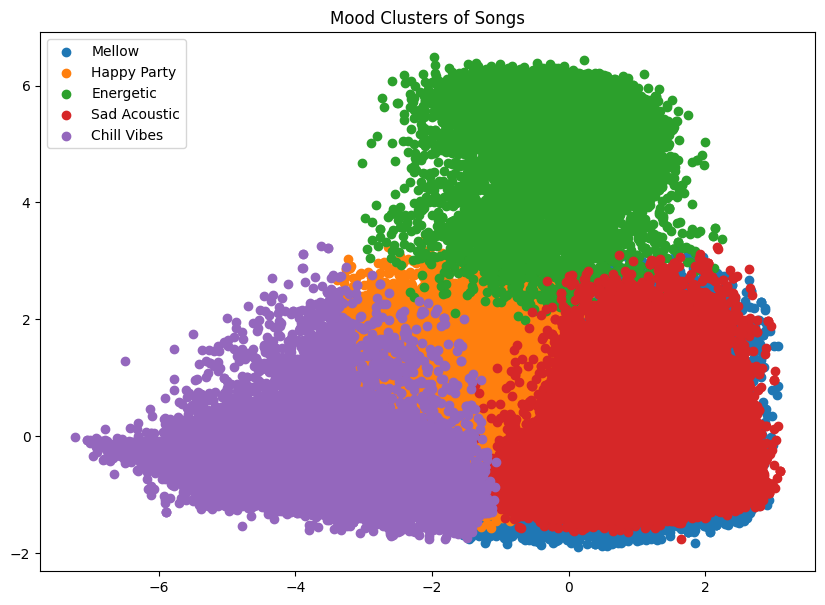

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

plt.figure(figsize=(10,7))
for mood in df['mood'].unique():
    subset = df[df['mood'] == mood]
    plt.scatter(subset['pca1'], subset['pca2'], label=mood)
    
plt.legend()
plt.title('Mood Clusters of Songs')
plt.show()

/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/gabyvega/ExpenseManagement/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  wa

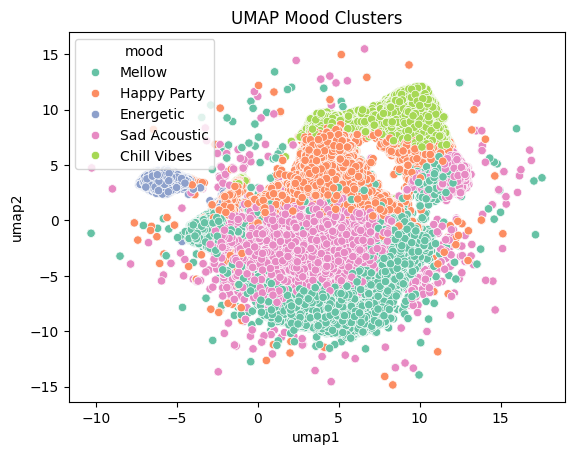

In [25]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

df['umap1'] = X_umap[:, 0]
df['umap2'] = X_umap[:, 1]

sns.scatterplot(x='umap1', y='umap2', hue='mood', data=df, palette='Set2')
plt.title("UMAP Mood Clusters")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# X_scaled = your standardized audio features
score = silhouette_score(X_scaled, df['mood_cluster'])
print(f"Silhouette Score: {score:.2f}")

In [ ]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(X_scaled, df['mood_cluster'])
print(f"Davies-Bouldin Index: {score:.2f}")

In [ ]:
from sklearn.metrics import calinski_harabasz_score

score = calinski_harabasz_score(X_scaled, df['mood_cluster'])
print(f"Calinski-Harabasz Index: {score:.2f}")

# <font color='#3c3c3c'>Handling Missing values</font>

# <font color='#3c3c3c'>Data Splitting</font>

# <font color='#3c3c3c'>Data Imputation</font>

# <font color='#3c3c3c'>Creating New Features</font>

# <font color='#3c3c3c'>Encoding Categorical Variables</font>

# <font color='#3c3c3c'>Feature Scaling</font>

# <font color='#3c3c3c'>Adressing Class Imbalance</font>

# <font color='#3c3c3c'>Feature Selection</font>

# <font color='#3c3c3c'>Baseline</font>